In [1]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import pandas as pd

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cv2
import scipy
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [134]:
import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, Softmax
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import LeakyReLU
from keras.layers import Lambda
from keras.layers import concatenate

In [305]:
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, cval=235, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor, zoom_factor) + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.full((17, 22, 3), (235, 235, 235))
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, cval=cval, **kwargs)

    # Zooming in
    elif zoom_factor > 1:
        out = zoom(img, zoom_tuple, cval=cval, **kwargs)
        #plt.imshow(out)
        #plt.show()

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [307]:
class ImageGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size):
        self.samples = samples
        self.batch_size = batch_size
        
    @property
    def n(self):
        return len(self.samples)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, i):
        x = []
        y = []
        for filepath, label in self.samples[i*self.batch_size:(i+1)*self.batch_size]:
            image = cv2.imread(filepath)
            for zoom_factor in np.linspace(0.9, 1.1, 5):
                zoomed_image = clipped_zoom(image, zoom_factor)
                zoomed_image = zoomed_image / 255.0
                x.append(zoomed_image)
                y.append(label)
        return (np.array(x), np.array(y))

In [308]:
def image_generator(dataframe, directory, batch_size, ratio=0.15):
    # validate filenames
    samples = []
    for i, row in dataframe.iterrows():
        filename = row['filename']
        total_digits = row['total_digits']
        left_digit = row['left_digit']
        right_digit = row['right_digit']
        
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath):
            continue
        
        label = np.zeros(22)
        if total_digits == 2:
            label[0] = 1
            label[2+left_digit] = 1
        else:
            label[1] = 1

        label[2+10+right_digit] = 1
        
        samples.append((filepath, label))
        
            
    np.random.shuffle(samples)
    
    print(f"Validated {len(samples)} files")
    
    total_validation = int(len(samples) * ratio)
    validation_samples = samples[:total_validation]
    training_samples = samples[total_validation:]
    
    return ImageGenerator(training_samples, batch_size), ImageGenerator(validation_samples, batch_size)

In [185]:
def prediction_to_digit(prediction):
    is_single_digit = np.argmax(prediction[0:2]) == 1
    
    left_digit = np.argmax(prediction[2:2+10])
    right_digit = np.argmax(prediction[2+10:2+10+10])

    if is_single_digit:
        return f"{right_digit}"
    else:
        return f"{left_digit}{right_digit}"

In [4]:
target_shape = (17, 22)

In [202]:
input_shape = (17, 22, 3)
alpha = 0.2

inputs = Input(shape=input_shape)

x = Conv2D(8, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (3, 3))(inputs)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3))(x)
x = LeakyReLU(alpha)(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(128)(x)
x = LeakyReLU(alpha)(x)

x = Dense(64)(x)
x = LeakyReLU(alpha)(x)

x = Dense(22)(x)

digit_type = Dense(2)(x)
left_digit = Dense(10)(x)
right_digit = Dense(10)(x)

digit_type = Softmax()(digit_type)
left_digit = Softmax()(left_digit)
right_digit = Softmax()(right_digit)




outputs = concatenate([digit_type, left_digit, right_digit])

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [203]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 17, 22, 3)    0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 15, 20, 16)   448         input_19[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_107 (LeakyReLU)     (None, 15, 20, 16)   0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_56 (MaxPooling2D) (None, 7, 10, 16)    0           leaky_re_lu_107[0][0]            
___________________________________________________________________________________________

In [309]:
dataframe = pd.read_csv("../assets/data/values/labels.txt", delim_whitespace=True)
training_generator, validation_generator = image_generator(dataframe, "../assets/data/values", 64)

Validated 10950 files


In [310]:
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=5,
)

Epoch 1/5
145/145 [==============================] - 58s 401ms/step - loss: 2.4322 - accuracy: 0.9423 - val_loss: 2.4452 - val_accuracy: 0.9485
Epoch 2/5
145/145 [==============================] - 55s 377ms/step - loss: 2.4267 - accuracy: 0.9447 - val_loss: 2.4435 - val_accuracy: 0.9314
Epoch 3/5
145/145 [==============================] - 54s 373ms/step - loss: 2.4238 - accuracy: 0.9422 - val_loss: 2.4430 - val_accuracy: 0.9364
Epoch 4/5
145/145 [==============================] - 55s 380ms/step - loss: 2.4216 - accuracy: 0.9394 - val_loss: 2.4413 - val_accuracy: 0.9330
Epoch 5/5
145/145 [==============================] - 54s 375ms/step - loss: 2.4200 - accuracy: 0.9355 - val_loss: 2.4452 - val_accuracy: 0.9476


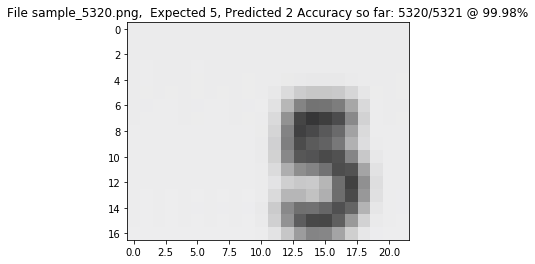

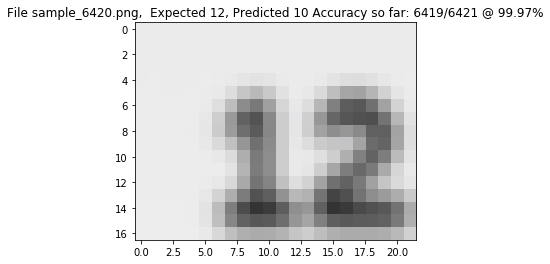

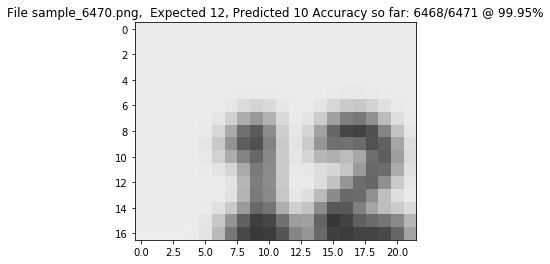

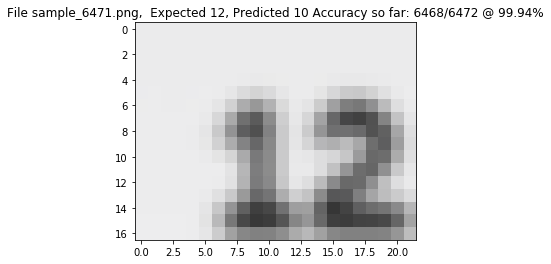

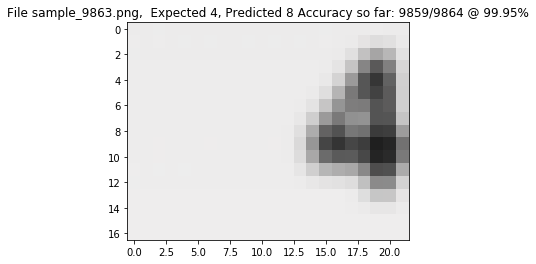

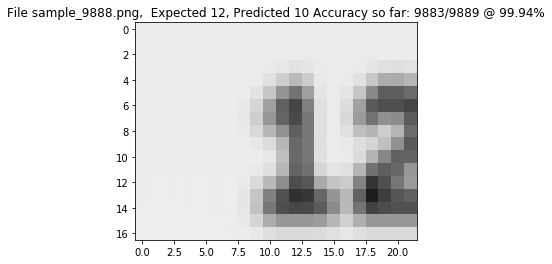

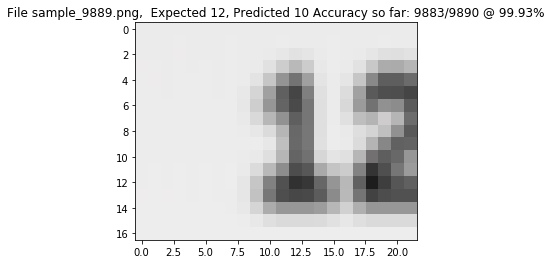

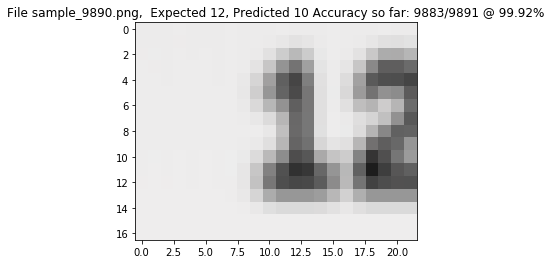

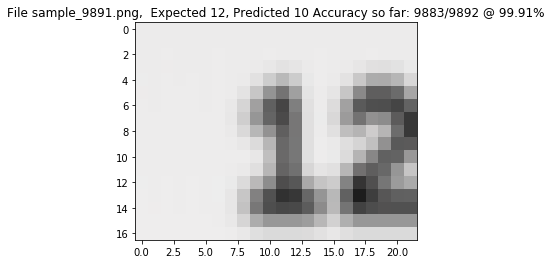

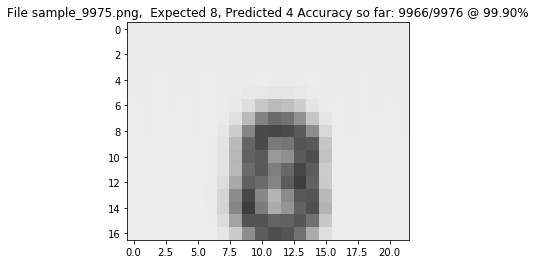

In [311]:
testing_dir = "../assets/data/values"
testing_dataframe = pd.read_csv(f"{testing_dir}/labels.txt", delim_whitespace=True)

total_samples = 0
total_correct = 0

for i, row in testing_dataframe.iterrows():
    filename = row['filename']
    total_digits = row['total_digits']
    left_digit = row['left_digit']
    right_digit = row['right_digit']
    
    if total_digits == 1:
        digit = f"{right_digit}"
    else:
        digit = f"{left_digit}{right_digit}"
    
    filepath = f"{testing_dir}/{filename}"
    if not os.path.exists(filepath):
        continue

    image = cv2.imread(filepath)
    image = image/255

    prediction = model.predict(np.array([image]))[0]
    predicted_string = prediction_to_digit(prediction)
    
    total_samples += 1
    
    if predicted_string != digit:
        plt.title(f"File {filename},  Expected {digit}, Predicted {predicted_string} "+
                  f"Accuracy so far: {total_correct}/{total_samples} @ {total_correct/total_samples * 100:.2f}%")
        plt.imshow(image)
        plt.show()
    else:
        total_correct += 1

In [312]:
model.save("two_digit_classifier.h5")